In [1]:
%matplotlib widget

In [2]:
import os
import shutil
import sys

import datetime
from tkinter import filedialog
import subprocess

import toml
from itertools import combinations
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.spatial.transform as st

import sleap_anipose as slap

In [3]:
NEWPROJECT = True
OVERWRITING = False

ROOTPATH = "D:/Project/SDANNCE-Models/4CAM-250620"

CAMVIEWS = 4  # Number of camera views (can be 2, 3, 4, 5, or 6)

CALIB = "20250620calib.mkv" # Put it inside ROOTPATH
EXP = "20250620-76225401-03-processed.mp4"
CUSTOMNAME = "20250620-toe3"

In [4]:
FFMPEG_PATH = "ffmpeg"
FFPROBE_PATH = "ffprobe"

def has_subfolders(folder_path):
    if not os.path.isdir(folder_path):
        return False
    with os.scandir(folder_path) as entries:
        for entry in entries:
            if entry.is_dir():
                return True
    return False

def vd_separ_calib(calib_dir, calibVid, numViews):
    
    try:
        ffprobe_cmd = [
            FFPROBE_PATH,
            "-v", "error",
            "-select_streams", "v:0",
            "-show_entries", "stream=width,height",
            "-show_entries", "format=duration",
            "-of", "default=noprint_wrappers=1:nokey=1",
            calibVid
        ]
        ffprobe_output = subprocess.check_output(ffprobe_cmd).decode("utf-8").strip().split('\n')
        width, height, duration_str = ffprobe_output
        width = int(width)
        height = int(height)
        total_duration = float(duration_str)

        # Assuming views are arranged in a x by 2 fashion (2 views a row)
        view_width = width // 2
        num_rows = numViews // 2 + 1 if numViews % 2 > 0 else numViews // 2
        view_height = height // num_rows

        ffmpeg_cmds = []
        skipped_views = []
        outputDirs = []

        for i in range(numViews):
            output_dir = os.path.join(calib_dir, f"view{i+1}", "calibration_images")
            outputDirs.append(output_dir)
            os.makedirs(output_dir, exist_ok=True)

        for i in range(numViews):
            row = i // 2
            col = i % 2
            x_offset = col * view_width
            y_offset = row * view_height
            output_file = os.path.join(outputDirs[i], f"SA_calib-view{i+1}-calibration.mp4")
            
            if os.path.exists(output_file):
                print(f"{output_file} already exists. Skipping view{i+1}")
                skipped_views.append(i)
            else:
                cmd = [
                    FFMPEG_PATH,
                    "-i", calibVid,
                    "-filter:v", f"crop={view_width}:{view_height}:{x_offset}:{y_offset}",
                    "-c:v", "libx264",
                    "-preset", "medium",
                    "-crf", "18",
                    "-progress", "pipe:1",
                    "-nostats",
                    output_file,
                ]
                ffmpeg_cmds.append(cmd)

        print("Starting video separation for calibration...")
        for i, cmd in enumerate(ffmpeg_cmds):
            current_view = i+1
            while current_view in skipped_views:
                current_view +=1 
            print(f"\nProcessing View {i+1}/{numViews-len(skipped_views)}")
            # Start subprocess with stdout as PIPE to capture progress
            process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)

            with tqdm(total=int(total_duration), unit="s", desc=f"View {current_view}") as pbar:
                for line in process.stdout:
                    if "time=" in line:
                        try:
                            # Extract time string (e.g., "00:00:15.12")
                            time_str = line.split("time=")[1].split(" ")[0]
                            h, m, s = map(float, time_str.split(':'))
                            current_time_seconds = h * 3600 + m * 60 + s
                            pbar.update(current_time_seconds - pbar.n) # Update with the difference
                        except (IndexError, ValueError):
                            pass # Ignore lines that don't parse as expected
            process.wait() # Wait for the process to complete

        print("Video separation complete.")
        return True

    except subprocess.CalledProcessError as e:
        print(f"FFmpeg error: {e}")
    except FileNotFoundError:
        print("FFmpeg or ffprobe not found. Make sure they are installed and in your PATH.")
    except Exception as e:
        print(f"An error occurred: {e}")

def vd_separ_exp(behVid, project_dir, numViews):

    try:
        if not os.path.isfile(behVid):
            print(f"Error: Input video path is not a file: {behVid}")
            return
        ffprobe_cmd = [
            FFPROBE_PATH,
            "-v", "error",
            "-select_streams", "v:0",
            "-show_entries", "stream=width,height",
            "-show_entries", "format=duration",
            "-of", "default=noprint_wrappers=1:nokey=1",
            behVid
        ]
        ffprobe_output = subprocess.check_output(ffprobe_cmd).decode("utf-8").strip().split('\n')
        width, height, duration_str = ffprobe_output
        width = int(width)
        height = int(height)
        total_duration = float(duration_str)

        # Assuming views are arranged in a x by 2 fashion (2 views a row)
        view_width = width // 2
        num_rows = numViews // 2 + 1 if numViews % 2 > 0 else numViews // 2
        view_height = height // num_rows
        main_output_folder = project_dir

        # Initialize folder structure
        cam_dirs = []
        for i in range(1, numViews + 1):
            cam_dir = os.path.join(main_output_folder, 'Videos', f'Camera{i}')
            cam_dirs.append(cam_dir)
            os.makedirs(cam_dir, exist_ok=True)

        # ffmpeg commands for each view
        ffmpeg_cmds = []
        for i in range(numViews):
            row = i // 2
            col = i % 2
            x_offset = col * view_width
            y_offset = row * view_height
            output_file = os.path.join(cam_dirs[i], "0.mp4")
            skipped_views = []
            if os.path.exists(output_file):
                print(f"{output_file} already exists. Skipping view{i+1}")
                skipped_views.append(i)
            else:
                cmd = [
                    FFMPEG_PATH,
                    "-i", behVid,
                    "-filter:v", f"crop={view_width}:{view_height}:{x_offset}:{y_offset}",
                    "-c:v", "libx264",
                    "-preset", "medium",
                    "-crf", "18",
                    "-progress", "pipe:1",
                    "-nostats",
                    output_file,
                ]
                ffmpeg_cmds.append(cmd)

        print("Starting video separation for experiment...")
        for i, cmd in enumerate(ffmpeg_cmds):
            current_view = i+1
            while current_view in skipped_views:
                current_view +=1 
            print(f"\nProcessing View {i+1}/{numViews-len(skipped_views)}")
            # Start subprocess with stdout as PIPE to capture progress
            process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)

            with tqdm(total=int(total_duration), unit="s", desc=f"View {current_view}") as pbar:
                for line in process.stdout:
                    if "time=" in line:
                        try:
                            time_str = line.split("time=")[1].split(" ")[0]
                            h, m, s = map(float, time_str.split(':'))
                            current_time_seconds = h * 3600 + m * 60 + s
                            pbar.update(current_time_seconds - pbar.n)
                        except (IndexError, ValueError):
                            pass
            process.wait()

        print("Video separation complete.")
        return True

    except subprocess.CalledProcessError as e:
        print(f"FFmpeg error: {e}")
    except FileNotFoundError:
        print("FFmpeg or ffprobe not found. Make sure they are installed and in your PATH.")
    except Exception as e:
        print(f"An error occurred: {e}")

def check_dannce_mat(dir):
    for file in os.listdir(dir):
        if file.endswith("_dannce.mat"):
            return True
    return False

In [5]:
def calculate_pairwise_distances(positions):
    """Calculates pairwise Euclidean distances between camera positions."""
    num_cameras = len(positions)
    distances = {}
    if num_cameras < 2:
        return distances
    for i, j in combinations(range(num_cameras), 2):
        pair_key = f"Cam{i+1}-Cam{j+1}" # Using 1-based indexing for user-friendliness
        dist = np.linalg.norm(positions[i] - positions[j])
        distances[pair_key] = dist
    return distances

def calculate_pairwise_angles(orientations):
    """Calculates pairwise angles (in degrees) between camera orientation vectors."""
    num_cameras = len(orientations)
    angles = {}
    if num_cameras < 2:
        return angles
    for i, j in combinations(range(num_cameras), 2):
        pair_key = f"Cam{i+1}-Cam{j+1}"
        dir1 = orientations[i] / np.linalg.norm(orientations[i]) # Ensure normalized
        dir2 = orientations[j] / np.linalg.norm(orientations[j]) # Ensure normalized
        dot_product = np.clip(np.dot(dir1, dir2), -1.0, 1.0) # Clip for numerical stability
        angle_rad = np.arccos(dot_product)
        angles[pair_key] = np.degrees(angle_rad)
    return angles

def calculate_relative_geometry_stats(positions, orientations, label=""):
    """Prints relative distances and angles for a set of cameras."""
    print(f"\n--- Relative Geometry Statistics for {label} ---")
    if len(positions) < 2:
        print("  Not enough cameras to calculate relative geometry.")
        return None, None
        
    rel_distances = calculate_pairwise_distances(positions)
    rel_angles = calculate_pairwise_angles(orientations)
    
    for pair_key in rel_distances.keys():
        dist_str = f"{rel_distances[pair_key]:.2f}"
        angle_str = f"{rel_angles.get(pair_key, float('nan')):.2f} deg" if pair_key in rel_angles else "N/A"
        print(f"  {pair_key}: Distance = {dist_str}, Angle = {angle_str}")
    return rel_distances, rel_angles

def compare_relative_geometries(orig_distances, orig_angles, new_distances, new_angles, orig_label="Original", new_label="Transformed"):
    """Compares and prints relative geometries of two sets of cameras."""
    #print(f"\n--- Comparison: {orig_label} vs. {new_label} Relative Geometry ---")
    if orig_distances is None or not orig_distances:
        print(f"  Cannot perform comparison: Missing or empty {orig_label} data.")
        return False
    if new_distances is None or not new_distances:
        print(f"  Cannot perform comparison: Missing or empty {new_label} data.")
        return False

    all_pair_keys = sorted(list(set(orig_distances.keys()) | set(new_distances.keys())))
    diff_tolerance = 1e-9

    for pair_key in all_pair_keys:
        
        orig_dist = orig_distances.get(pair_key, float('nan'))
        new_dist = new_distances.get(pair_key, float('nan'))
        if abs(orig_dist - new_dist) > diff_tolerance:
            print(f"  Pair: {pair_key}")
            print(f"    Relative Distance Mismatch: {orig_label} = {orig_dist:.2f}, {new_label} = {new_dist:.2f}",
                f"\nDifference: {abs(orig_dist - new_dist):.10f}")
            return False
        
        orig_angle_val = orig_angles.get(pair_key, float('nan')) if orig_angles else float('nan')
        new_angle_val = new_angles.get(pair_key, float('nan')) if new_angles else float('nan')
        if abs(orig_angle_val - new_angle_val) > diff_tolerance:
            print(f"  Pair: {pair_key}")
            print(f"    Relative Angle Mismatch:    {orig_label} = {orig_angle_val:.2f} deg, {new_label} = {new_angle_val:.2f} deg"
                f"\nDifference: {abs(orig_angle_val - new_angle_val):.10f}")
            return False

    return True

def plot_relative_geometry(ax, cam_pos, cam_dir, numCam, cam_name, intersect):
    """
    Plots the relative geometry on a given Axes3D object.
    Does NOT create a new figure or call plt.show().
    """
    ax.set_title(str(cam_name))

    for i in range(numCam):
        ax.scatter(*cam_pos[i], s=100, label=f"{cam_name} {i+1} Pos")
        ax.quiver(*cam_pos[i], *cam_dir[i], length=100, color='blue', normalize=True)
    ax.scatter(*intersect, color='black', s=200, marker='X', label=f'{cam_name} Intersection')

    # Plot ground plane
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    X, Y = np.meshgrid(np.linspace(xlim[0], xlim[1], 10), np.linspace(ylim[0], ylim[1], 10))
    Z = np.zeros_like(X)
    ax.plot_surface(X, Y, Z, alpha=0.1, color='gray')
        
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.legend()

def process_sleap_calibration(calib_dir, show_plots=True, save_mat_files=True):
    """
    Processes a SLEAP calibration file to transform camera parameters,
    visualize the setup, and export results to .mat files.

    Args:
        calib_dir (str): The directory containing the 'calibration.toml' file.
        show_plots (bool): If True, displays the 3D plots for visualization.
        save_mat_files (bool): If True, saves the transformed parameters to .mat files.

    Returns:
        bool: True if processing was successful, False otherwise.
    """
    sleap_calib_path = os.path.join(calib_dir, 'calibration.toml')
    
    if not os.path.exists(sleap_calib_path):
        print(f"Error: Calibration file not found at {sleap_calib_path}")
        return False

    try:
        with open(sleap_calib_path, 'r') as f:
            sCal = toml.load(f)
    except Exception as e:
        print(f"Error reading or parsing TOML file: {e}")
        return False

    camera_names = []
    camera_positions = []
    original_cam_dirs_list = []
    original_params_list = []
    cam_count = 0

    # --- Step 1: Extract Original Camera Parameters ---
    for camera_name, camera_data in sCal.items():
        if 'matrix' in camera_data:
            cam_count += 1
            
            # Extract original parameters from the TOML file
            K_orig = np.array(camera_data['matrix']).T
            rotations_orig_vec = np.array(camera_data['rotation'])
            R_orig = st.Rotation.from_rotvec(rotations_orig_vec).as_matrix()
            t_orig = np.array(camera_data['translation'])
            RDistort_orig = np.array(camera_data['distortions'][0:2])
            TDistort_orig = np.array(camera_data['distortions'][2:4])

            original_params_list.append({
                'name': camera_name, 'K': K_orig, 'R_orig': R_orig,
                'RDistort': RDistort_orig, 'TDistort': TDistort_orig,
                't_orig': t_orig
            })

            # Calculate camera position and orientation in world coordinates
            cam_pos = -np.dot(R_orig.T, t_orig)
            cam_dir = R_orig[2, :]  # Principal axis from the 3rd row of rotation matrix

            camera_positions.append(cam_pos)
            original_cam_dirs_list.append(cam_dir)
            camera_names.append(camera_name)

    if not camera_positions:
        print("No camera data with a 'matrix' key found in the calibration file.")
        return False
        
    camera_positions = np.array(camera_positions)
    original_cam_dirs = np.array(original_cam_dirs_list)

    # Calculate relative geometry before transposing for validation
    rel_dist_org, rel_ang_org = calculate_relative_geometry_stats(camera_positions, original_cam_dirs, "Pre-transpose")

    # Find the point of closest intersection of the camera orientation rays
    A_lstsq = np.vstack([np.eye(3) - np.outer(d, d) for d in original_cam_dirs])
    b_lstsq = np.hstack([(np.eye(3) - np.outer(d, d)) @ p for p, d in zip(camera_positions, original_cam_dirs)])
    P_intersect_orig = np.linalg.lstsq(A_lstsq, b_lstsq, rcond=None)[0]

    # --- Step 2: Define Transformation to Align with Ground Plane ---
    # Fit a plane to the camera positions to find the normal vector
    centroid = np.mean(camera_positions, axis=0)
    covariance_matrix = np.cov(camera_positions - centroid, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    normal_vector = eigenvectors[:, np.argmin(eigenvalues)]

    if normal_vector[2] < 0:
        normal_vector *= -1  # Ensure normal points upwards

    # Calculate rotation to align the camera plane with the XY ground plane (normal = [0,0,1])
    ground_normal = np.array([0, 0, 1])
    rotation_vector = np.cross(normal_vector, ground_normal)
    rotation_vector_norm = np.linalg.norm(rotation_vector)
    
    rotation_axis = rotation_vector / rotation_vector_norm
    if np.linalg.norm(rotation_axis) > 1e-6:
        rotation_angle = np.arccos(np.dot(normal_vector, ground_normal))
        rotation = st.Rotation.from_rotvec(rotation_axis * rotation_angle)
        plane_rotation_matrix = rotation.as_matrix()
    else:
        plane_rotation_matrix = np.eye(3)

    # --- Step 3: Apply Transformations ---
    # Translate intersection point to origin (Z=0) and rotate cameras around it
    rotated_P_intersect = np.dot(plane_rotation_matrix, (P_intersect_orig - centroid))
    target_intersection_z = 0.0
    z_translation = target_intersection_z - rotated_P_intersect[2]

    transformed_positions = np.dot(plane_rotation_matrix, (camera_positions - centroid).T).T 
    transformed_positions[:, 2] += z_translation
    
    final_P_intersect = rotated_P_intersect + np.array([0, 0, z_translation])

    # Apply a 180-degree rotation around the X-axis to flip the coordinate system
    R_180_x = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])
    
    temp_transformed_positions = np.zeros_like(transformed_positions)
    for i in range(len(transformed_positions)):
        pos_relative_to_intersect = transformed_positions[i] - final_P_intersect
        rotated_pos_relative = R_180_x @ pos_relative_to_intersect
        temp_transformed_positions[i] = rotated_pos_relative + final_P_intersect
    transformed_positions = temp_transformed_positions

    transformed_orientations = []
    plot_cam_idx = 0 # Use a 0-based index for plotting transformed cameras
    for camera_name, camera_data in sCal.items():
        if 'matrix' in camera_data:
            original_dir_for_this_cam = original_cam_dirs[plot_cam_idx]
            intermediate_dir = np.dot(plane_rotation_matrix, original_dir_for_this_cam)
            transformed_dir = R_180_x @ intermediate_dir
            transformed_orientations.append(transformed_dir)
            plot_cam_idx +=1

    transformed_orientations_np = np.array(transformed_orientations)
    rel_dist_post, rel_ang_post = calculate_relative_geometry_stats(transformed_positions, transformed_orientations_np, "Post-transpose")
    if rel_dist_org and rel_dist_post:
        if not compare_relative_geometries(rel_dist_org, rel_ang_org, rel_dist_post, rel_ang_post, new_label="Post-transpose"):
            print("Relative geometry mismatch from transpose detected, aborting...")
            fig = plt.figure(figsize=(10, 5))
            ax1 = fig.add_subplot(1, 2, 1, projection='3d')
            ax2 = fig.add_subplot(1, 2, 2, projection='3d')
            plot_relative_geometry(ax1, camera_positions, original_cam_dirs, cam_count, 'Original', P_intersect_orig)
            plot_relative_geometry(ax2, transformed_positions, transformed_orientations_np, cam_count, 'Rotated', final_P_intersect)
            return False
        
    # --- Step 4: Save Transformed .mat Files ---
    if save_mat_files:
        print("\nExporting transformed camera parameters to .mat files...")
        for i, orig_params in enumerate(original_params_list):
            # Combine all rotations
            #R_new_from_org = 
            R_final = orig_params['R_orig'] @ plane_rotation_matrix.T @ R_180_x
            P_final= transformed_positions[i]
            # New translation vector t = -R * C
            t_final = -R_final @ P_final.T

            mat_data = {
                'K': orig_params['K'],
                'RDistort': orig_params['RDistort'],
                'TDistort': orig_params['TDistort'],
                'r': R_final.T,
                't': t_final
            }
            
            mat_filename = f"hires_cam{i+1}_params.mat"
            calibration_folder = os.path.join(calib_dir, "Calibration")
            mat_save_path = os.path.join(calibration_folder, mat_filename)
            os.makedirs(calibration_folder, exist_ok=True)
            sio.savemat(mat_save_path, mat_data)
            print(f"Saved: {mat_filename} for camera '{orig_params['name']}'")

    # --- Step 5: Load and Validate Saved .mat Files ---
    mat_file_list = []
    for i in range(cam_count):
        mat_file_list.append(f"hires_cam{i+1}_params.mat")

    folder_files = os.listdir(calibration_folder)

    # Check if ALL files in mat_file_list are present in files_in_folder
    if all(filename in folder_files for filename in mat_file_list):
        print("All .mat located, proceed to load and validate.")
    else:
        print("Missing .mat files. Saving process has probably failed.")
        missing_files = [filename for filename in mat_file_list if filename not in folder_files]
        print(f"Missing files: {missing_files}")
        return False
    
    mat_cam_positions = []
    mat_cam_orientations = []

    for matfile in mat_file_list:
        matfile_path = os.path.join(calibration_folder, matfile)
        mat_data = sio.loadmat(matfile_path)
        r = mat_data['r'].T
        t = mat_data['t'].flatten()

        # Camera orientation
        cam_dir = r[2, :]
        mat_cam_orientations.append(cam_dir)

        # Calculate camera position from rotation and translation
        cam_pos = -np.dot(r.T, t)
        mat_cam_positions.append(cam_pos)

    mat_cam_positions = np.array(mat_cam_positions)
    mat_cam_orientations = np.array(mat_cam_orientations)

    # Find the point of closest intersection of the camera orientation rays
    C_lstsq = np.vstack([np.eye(3) - np.outer(ef, ef) for ef in mat_cam_orientations])
    D_lstsq = np.hstack([(np.eye(3) - np.outer(ef, ef)) @ ep for ep, ef in zip(mat_cam_positions, mat_cam_orientations)])
    mat_intersect = np.linalg.lstsq(C_lstsq, D_lstsq, rcond=None)[0]

    rel_dist_mat, rel_ang_mat = calculate_relative_geometry_stats(mat_cam_positions, mat_cam_orientations, "Geometry from .mat Files")

    if rel_dist_org and rel_dist_mat:
        if not compare_relative_geometries(rel_dist_org, rel_ang_org, rel_dist_mat, rel_ang_mat, new_label=".mat"):
            print("Relative geometry mismatch from .mat detected, aborting...")
            fig = plt.figure(figsize=(10, 5))
            ax1 = fig.add_subplot(1, 2, 1, projection='3d')
            ax2 = fig.add_subplot(1, 2, 2, projection='3d')
            plot_relative_geometry(ax1, camera_positions, original_cam_dirs, cam_count, 'Original', P_intersect_orig)
            plot_relative_geometry(ax2, mat_cam_positions, mat_cam_orientations, cam_count, ".mat", mat_intersect)
            return False

    # --- Step 6: Visualize Results ---
    if show_plots:
        fig = plt.figure(figsize=(15, 5))

        ax1 = fig.add_subplot(1, 3, 1, projection='3d')
        ax2 = fig.add_subplot(1, 3, 2, projection='3d')
        ax3 = fig.add_subplot(1, 3, 3, projection='3d')

        plot_relative_geometry(ax1, camera_positions, original_cam_dirs, cam_count, 'Original', P_intersect_orig)
        plot_relative_geometry(ax2, transformed_positions, transformed_orientations_np, cam_count, 'Rotated', final_P_intersect)
        plot_relative_geometry(ax3, mat_cam_positions, mat_cam_orientations, cam_count, ".mat", mat_intersect)

        plt.tight_layout()
        plt.show()

In [6]:
def get_cam_count(base_folder):
    if not os.path.isdir(base_folder):
        print(f"Error: Camera videos folder not found at {base_folder}", file=sys.stderr)
        return 0
    count = 0
    for root, dirs, files in os.walk(base_folder):
        if root.split(os.sep)[-1].startswith('Camera'):
            if '0.mp4' in files:
                count += 1
    return count

def get_calib_count(base_folder):
    if not os.path.isdir(base_folder):
        print(f"Error: Calibration folder not found at {base_folder}", file=sys.stderr)
        return 0
    count = 0
    for files in os.listdir(base_folder):
        if files.startswith('hires_cam'):
            count += 1
    return count

def get_frame_count(video_path):
    command = [
        FFPROBE_PATH,
        '-v', 'error',
        '-select_streams', 'v:0',
        '-count_frames',
        '-show_entries', 'stream=nb_read_frames',
        '-of', 'default=nokey=1:noprint_wrappers=1',
        video_path
    ]
    try:
        result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, check=True)
        return int(result.stdout.strip())
    except FileNotFoundError:
        print(f"Error: 'ffprobe' command not found. Make sure FFmpeg is installed and in your PATH.", file=sys.stderr)
        return None
    except subprocess.CalledProcessError as e:
        print(f"Error running ffprobe for {video_path}: {e.stderr}", file=sys.stderr)
        return None
    except ValueError:
        print(f"Error: Could not parse frame count for {video_path}.", file=sys.stderr)
        return None

def generate_sync(projectDir,numViews):
    numCam = get_cam_count(os.path.join(projectDir, 'Videos'))
    print(f'Found {numCam} camera views.')
    numCalib = get_calib_count(os.path.join(projectDir, 'Calibration'))
    print(f'Found {numCalib} calibration files.')

    if numCam == 0:
        return False, f"Error: no camera views found in {projectDir}."
    elif numCalib == 0:
        return False, f"Error: no calibration files found in {projectDir}."
    elif numCam != numCalib:
        return False, f'Error: calibration ({numCalib}) and camera views ({numCam}) do not match!'
    else:
        if numViews > numCam:
            return False, f"Error: camera views in {projectDir} is less than project designation."
        if numViews < numCam:
            print(f"Using only the first {numViews} cameras.")
            numCam = numViews

        videosample = os.path.join(projectDir, 'Videos', 'Camera1', '0.mp4')
        print('---Getting the frame counts---')
        framecount = get_frame_count(videosample)

        camnames = [f"Camera{i+1}" for i in range(numCam)]
        params = []
        sync = []

        for i in range(numCam):
                
                print(f'---Processing {camnames[i]}---')
                data_2d = np.zeros((framecount, 4))
                data_3d = np.zeros((framecount, 6))
                data_frame = np.arange(framecount, dtype=np.float64)
                data_sampleID = np.arange(framecount, dtype=np.float64)

                cam_struct = {
                        'data_2d': data_2d,
                        'data_3d': data_3d,
                        'data_frame': data_frame,
                        'data_sampleID': data_sampleID
                    }
                
                calibFile = os.path.join(projectDir, 'Calibration', f'hires_cam{i+1}_params.mat')
                params_struct = sio.loadmat(calibFile)

                sync.append(cam_struct)
                params.append(params_struct)

        camnames_array = np.array(camnames, dtype=object)
        params_array = np.array(params, dtype=object).reshape(numCam, 1)
        sync_array = np.array(sync, dtype=object).reshape(numCam, 1)

        mat_data_to_save = {
            'camnames': camnames_array,
            'params': params_array,
            'sync': sync_array
            }
        output_mat_filename = 'sync_dannce.mat'
        output_mat_path = os.path.join(projectDir, output_mat_filename)
        sio.savemat(output_mat_path, mat_data_to_save)
        print(f"\nAll camera sync data saved to: {output_mat_path}")
        return True

In [7]:
def _select_and_copy_video(video_name, root_path, prompt_message, supported_extensions=('.mp4', '.avi', '.mkv')):
    """
    Helper function to select a video file using a dialog and copy it to a root path.
    Returns the path to the selected/copied video, or None if cancelled/failed.
    Exits the script if the user cancels the dialog.
    """
    video_path_in_root = os.path.join(root_path, video_name)

    if not os.path.exists(video_path_in_root):
        print(prompt_message)
        while True:
            selected_file = filedialog.askopenfilename(
                title=f"Select {video_name}",
                filetypes=[("Video files", " ".join(f"*{ext}" for ext in supported_extensions)), ("All files", "*.*")]
            )
            if not selected_file:  # User cancelled the dialog
                print(f"No {video_name} selected.")
                return None
            if selected_file.lower().endswith(supported_extensions):
                break
            print(f"{selected_file} is not among supported video formats ({'/'.join(ext.strip('.') for ext in supported_extensions)}). Please select another one.")
        
        print("Selected file:", selected_file)
        try:
            shutil.copy(selected_file, root_path)
            print(f"Selected file copied to {root_path}")
            return os.path.join(root_path, os.path.basename(selected_file)) # Return path to the copied file
        except Exception as e:
            print(f"Error copying selected file to {root_path}: {e}")
            return None
    return video_path_in_root # Return existing path if already in root

def select_and_process_calibration_video(root_path, calib_name, cam_views):
    """
    Handles selection, copying, and separation of the video.
    Returns True on success, False on failure or cancellation.
    """
    prompt = f"{calib_name} not found in {root_path}. Please select the calibration video."
    calib_vid_path = _select_and_copy_video(calib_name, root_path, prompt)
    calib_dir = os.path.join(root_path, "SA_calib")

    if vd_separ_calib(calib_dir, calib_vid_path, cam_views):
        print("Calibration video separation successful.")
        return True
    else:
        print("Calibration video separation failed.")
        return False

def select_and_process_experiment_video(project_dir, root_path, exp_name, cam_views):
    """
    Handles selection, copying, and separation of the video.
    Returns True on success, False on failure or cancellation.
    """
    prompt = f"{exp_name} not found in {root_path}. Please select the experiment video."
    exp_vid_path = _select_and_copy_video(exp_name, root_path, prompt)

    if vd_separ_exp(exp_vid_path, project_dir, cam_views):
        print("Experiment video separation successful.")
        return True
    else:
        print("Experiment video separation failed.")
        return False

def duplicate_calibration_files(source_calib_dir, project_dir, expected_calib_file_path):
    """
    Duplicates calibration files to the project directory.
    Returns True on success, False on failure.
    """
    calib_result_path = os.path.join(source_calib_dir, "Calibration")
    calib_dest_path = os.path.join(project_dir, "Calibration")

    if not os.path.exists(calib_result_path):
        print(f"Error: Calibration source directory not found at {calib_result_path}.")
        return False

    print(f"Duplicating calibration files from {calib_result_path} to {calib_dest_path}...")
    try:
        shutil.copytree(calib_result_path, calib_dest_path, dirs_exist_ok=True)
        if os.path.exists(expected_calib_file_path):
            print(f"Calibration files duplicated to {calib_dest_path} successfully.")
            return True
        else:
            print(f"Calibration duplication appeared to succeed, but {expected_calib_file_path} not found.")
            return False
    except Exception as e:
        print(f"Error duplicating calibration files to {calib_dest_path}: {e}")
        return False

def generate_sync_profile(project_dir,numViews):
    """
    Generates the combined sync profile.
    Returns True on success, False on failure.
    """
    print(f"Generating sync profile for {project_dir}...")
    if generate_sync(project_dir,numViews):
        print("Combined sync profile generated successfully.")
        return True
    else:
        print("Combined sync profile generation failed.")
        return False

def check_project_legit(exp_max_path, project_dir, calib_max_path):
    """Checks if the project is legitimate based on required files."""
    return (
        os.path.exists(exp_max_path) and
        check_dannce_mat(project_dir) and
        os.path.exists(calib_max_path)
    )

In [8]:
if not os.path.isdir(ROOTPATH):
    print(f"{ROOTPATH} does not exist. Creating now...")
    os.makedirs(ROOTPATH, exist_ok=True)

rootPathFolders = os.listdir(ROOTPATH)
sdFolders = [ rpf for rpf in rootPathFolders if rpf.startswith ("SD-") ]

curTime = datetime.datetime.now()
curTime_formatted = curTime.strftime("%Y%m%d%H%M%S")

projectName = None
if sdFolders and not NEWPROJECT:
    if sdFolders and len(sdFolders) == 1:
        projectName = str(sdFolders[0])
        print(f"Project folder found in {ROOTPATH}. Loading {projectName}")
    else:
        print(f"Multiple project folders found in {ROOTPATH}. Choose which to load.")
        for i, folder in enumerate(sdFolders, 1):
            print(f"{i}: {folder}")

        while projectName is None:
            try:
                choice = int(input("Enter selection number: ")) - 1
                if 0 <= choice < len(sdFolders):
                    projectName = str(sdFolders[choice])
                else:
                    print("Invalid selection")
            except ValueError:
                print("Invalid input (must be a number)")
            except KeyboardInterrupt:
                print("\nProject selection cancelled. Exiting.")
                sys.exit("User cancelled project selection.")

else:
    if not sdFolders:
        print(f"No existing 'SD-' project folders found in {ROOTPATH}. Creating a new project...")
    elif NEWPROJECT:
        print(f"Existing 'SD-' project folders found, but creating a new project as specified by NEWPROJECT=True...")

    tempName = ""
    if CUSTOMNAME and CUSTOMNAME.strip():
        tempName = f"SD-{CUSTOMNAME.strip()}"
    else:
        tempName = f"SD-{curTime_formatted}"

    # Handle name collisions for the new project
    while os.path.exists(os.path.join(ROOTPATH, tempName)):
        print(f"Warning: Project folder '{tempName}' already exists.")
        if CUSTOMNAME and CUSTOMNAME.strip() and tempName == f"SD-{CUSTOMNAME.strip()}":
            newName = input("Please enter a new, unique custom name for the project (leave blank for timestamped): ").strip()
            if newName:
                tempName = f"SD-{newName}"
            else:
                # If blank, use a new timestamp
                tempName = f"SD-{datetime.datetime.now().strftime('%Y%m%d%H%M%S')}"
                print(f"Generating new timestamped name: {tempName}")
        else:
            tempName = f"SD-{datetime.datetime.now().strftime('%Y%m%d%H%M%S')}"
            print(f"Generating new timestamped name: {tempName}")
        
    projectName = tempName
    print(f"Determined new project name: {projectName}")

PROJECTDIR = os.path.join(ROOTPATH,projectName)

Existing 'SD-' project folders found, but creating a new project as specified by NEWPROJECT=True...
Determined new project name: SD-20250620-toe3


In [9]:
boardPic = os.path.join(ROOTPATH,"board.jpg")
boardToml = os.path.join(ROOTPATH,"board.toml")
isBoardLegit = os.path.exists(boardPic) and os.path.exists(boardToml)
if isBoardLegit and not OVERWRITING:
    print("Existing board.png and board.toml detected. Skipping...")
elif isBoardLegit and OVERWRITING:
    print("Overwriting status set to True, overwriting current board configurations...")
else:
    print(f"Generating calibration board and configuration at {ROOTPATH}...")
    slap.draw_board(board_name = boardPic, 
                board_x = 8, 
                board_y = 11, 
                square_length = 24.0, 
                marker_length = 19.75, 
                marker_bits = 4, 
                dict_size = 1000, 
                img_width = 1440, 
                img_height = 1440, 
                save = boardToml)

Generating calibration board and configuration at D:/Project/SDANNCE-Models/4CAM-250620...


No existing calibration found, proceeding to calibration process...
Starting video separation for calibration...

Processing View 1/4


View 1:  94%|█████████▍| 91.46000000000001/97 [00:07<00:00, 12.09s/s]d:\Anaconda\envs\sleap-anipose\lib\site-packages\tqdm\std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
View 1: 100%|██████████| 97.46000000000001/97 [00:08<00:00, 11.85s/s]



Processing View 2/4


View 2: 100%|██████████| 97.46000000000001/97 [00:07<00:00, 12.81s/s]



Processing View 3/4


View 3: 100%|██████████| 97.46000000000001/97 [00:08<00:00, 11.28s/s]



Processing View 4/4


View 4: 100%|██████████| 97.46000000000001/97 [00:07<00:00, 12.59s/s]


Video separation complete.
Calibration video separation successful.
---Starting calibration now---
D:/Project/SDANNCE-Models/4CAM-250620/SA_calib/view1/calibration_images/SA_calib-view1-calibration.mp4


100%|█████████████████████████████| 4875/4875 [02:14<00:00, 36.19it/s]


4860 boards detected
D:/Project/SDANNCE-Models/4CAM-250620/SA_calib/view2/calibration_images/SA_calib-view2-calibration.mp4


100%|█████████████████████████████| 4875/4875 [02:04<00:00, 39.11it/s]


4875 boards detected
D:/Project/SDANNCE-Models/4CAM-250620/SA_calib/view3/calibration_images/SA_calib-view3-calibration.mp4


100%|█████████████████████████████| 4875/4875 [02:02<00:00, 39.87it/s]


4873 boards detected
D:/Project/SDANNCE-Models/4CAM-250620/SA_calib/view4/calibration_images/SA_calib-view4-calibration.mp4


100%|█████████████████████████████| 4875/4875 [01:58<00:00, 41.02it/s]


4875 boards detected
defaultdict(<class 'int'>,
            {('view1', 'view2'): 4761,
             ('view1', 'view3'): 4816,
             ('view1', 'view4'): 4815,
             ('view2', 'view1'): 4761,
             ('view2', 'view3'): 4816,
             ('view2', 'view4'): 4808,
             ('view3', 'view1'): 4816,
             ('view3', 'view2'): 4816,
             ('view3', 'view4'): 4863,
             ('view4', 'view1'): 4815,
             ('view4', 'view2'): 4808,
             ('view4', 'view3'): 4863})
error:  2.890250579233842
n_samples: 200
{(0, 1): (5880, array([2.91007801, 4.1366539 ])),
 (0, 2): (5880, array([3.01465105, 4.49144894])),
 (0, 3): (5880, array([2.63616594, 3.67066293])),
 (1, 2): (5880, array([1.81255225, 3.10917261])),
 (1, 3): (5880, array([1.3641024 , 2.35194431])),
 (2, 3): (5880, array([1.41815708, 2.75809173]))}
error: 2.87, mu: 4.5, ratio: 0.979
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0        

d:\Anaconda\envs\sleap-anipose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Anaconda\envs\sleap-anipose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Save path = D:/Project/SDANNCE-Models/4CAM-250620\SA_calib
Save path = D:/Project/SDANNCE-Models/4CAM-250620\SA_calib
Save path = D:/Project/SDANNCE-Models/4CAM-250620\SA_calib
Save path = D:/Project/SDANNCE-Models/4CAM-250620\SA_calib
Save path = D:/Project/SDANNCE-Models/4CAM-250620\SA_calib
Save path = D:/Project/SDANNCE-Models/4CAM-250620\SA_calib
Save path = D:/Project/SDANNCE-Models/4CAM-250620\SA_calib
Save path = D:/Project/SDANNCE-Models/4CAM-250620\SA_calib
Save path = D:/Project/SDANNCE-Models/4CAM-250620\SA_calib
Save path = D:/Project/SDANNCE-Models/4CAM-250620\SA_calib
Save path = D:/Project/SDANNCE-Models/4CAM-250620\SA_calib
Save path = D:/Project/SDANNCE-Models/4CAM-250620\SA_calib
Save path = D:/Project/SDANNCE-Models/4CAM-250620\SA_calib
Save path = D:/Project/SDANNCE-Models/4CAM-250620\SA_calib
Save path = D:/Project/SDANNCE-Models/4CAM-250620\SA_calib
Save path = D:/Project/SDANNCE-Models/4CAM-250620\SA_calib

--- Relative Geometry Statistics for Pre-transpose ---


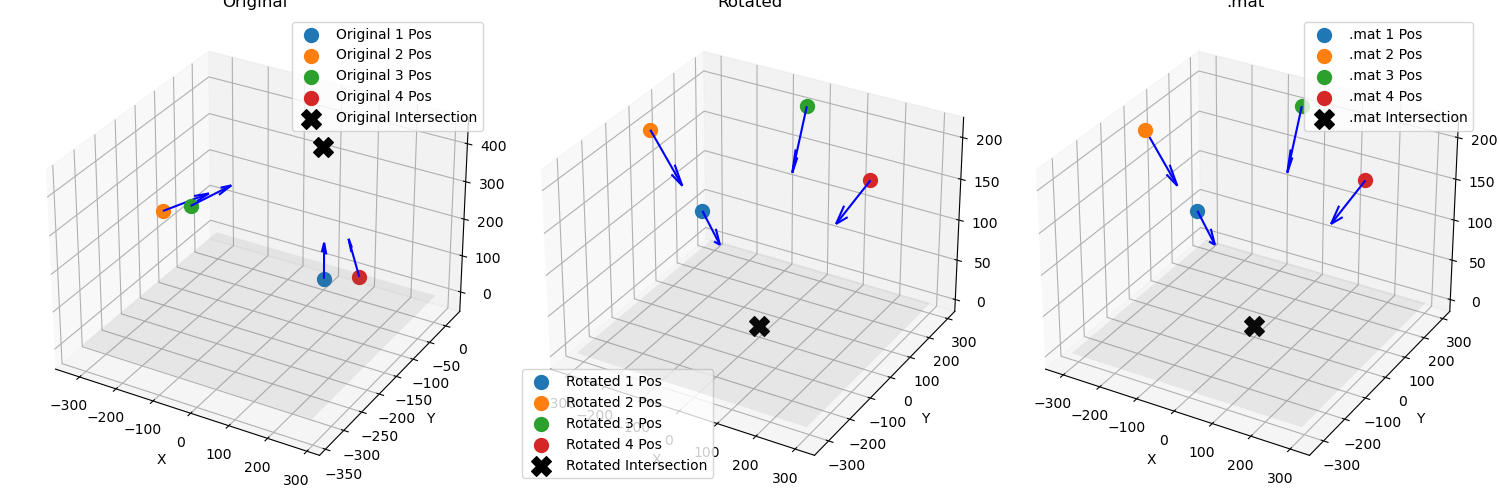

Calibration finished!


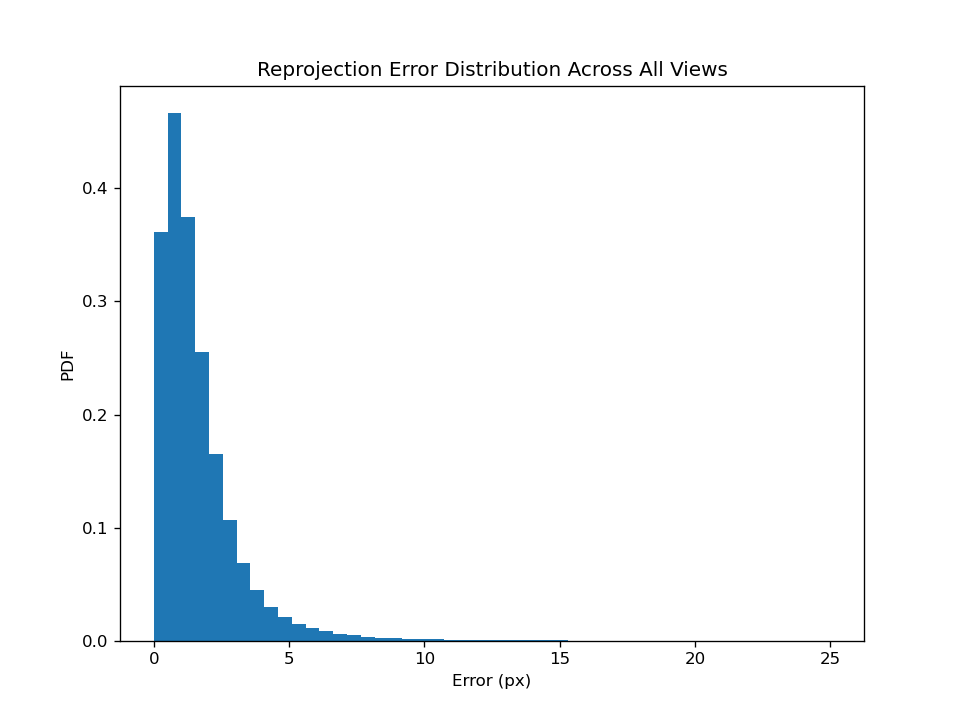

In [10]:
calibDir = os.path.join(ROOTPATH,"SA_calib")
calibCalib = os.path.join(calibDir, "Calibration", f"hires_cam{CAMVIEWS}_params.mat")

isCalibLegit = os.path.isdir(calibDir) and "calibration.toml" in os.listdir(calibDir)
if isCalibLegit and OVERWRITING:
    print("Existing calibration found! Though you set OVERWRITING to True, calibration can be a lengthy progress!")
    try:
        askUserCalib = str(input("Press 'y' to redo the calibration process, press 'n' to skip it:"))
        if askUserCalib == "y":
            print("Backing up the original SA_calib...")
            shutil.move(calibDir,os.path.join(ROOTPATH,f"SA_calib_BACKUP-{curTime_formatted}"))
            calibStatus = False
            os.makedirs(calibDir,exist_ok = True)
        if askUserCalib == "n":
            print("Skipping the calibration as per user's instructions...")
            calibStatus = True
    except ValueError:
        print("Invalid input (must be 'y' or 'n')")
elif isCalibLegit and not OVERWRITING:
    print("Existing calibration found!")
    if not os.path.exists(calibCalib):
        print('Transposed calibration not found, proceeding to transpose process...')
        process_sleap_calibration(calibDir, show_plots=True, save_mat_files=True)
    calibStatus = True
else:
    print("No existing calibration found, proceeding to calibration process...")
    calibStatus = False
    os.makedirs(calibDir,exist_ok = True)

if calibStatus == False:
    shutil.copy(boardPic,calibDir)
    shutil.copy(boardToml,calibDir)
    calibVid = os.path.join(ROOTPATH, CALIB)
    if select_and_process_calibration_video(ROOTPATH, CALIB, CAMVIEWS):
        print("---Starting calibration now---")
        cgroup, metadata = slap.calibrate(session = str(calibDir),
                                        board = f"{calibDir}/board.toml", 
                                        excluded_views = (),
                                        calib_fname = f"{calibDir}/calibration.toml", 
                                        metadata_fname = f"{calibDir}/calibration.metadata.h5", 
                                        histogram_path = f"{calibDir}/reprojection_histogram.png", 
                                        reproj_path = str(calibDir))
        if not process_sleap_calibration(calibDir, show_plots=True, save_mat_files=True):
            if os.path.exists(calibCalib):
                print("Calibration finished!")
            else:
                print("Calibration failed!")
        else:
            print("Calibration transformation failed!")
            shutil.rmtree(os.path.join(calibDir,"Calibration"))

In [11]:
expMaxPath = os.path.join(PROJECTDIR,"Videos",f"Camera{CAMVIEWS}","0.mp4")
calibMaxPath = os.path.join(PROJECTDIR,"Calibration",f"hires_cam{CAMVIEWS}_params.mat")

isProjectLegit = check_project_legit(expMaxPath, PROJECTDIR, calibMaxPath)

if isProjectLegit and not OVERWRITING:
    print("Existing project files detected. Skipping...")
elif isProjectLegit and OVERWRITING:
    print("Overwriting existing project files as ordered...")

    print("Overwriting experiment videos...")
    select_and_process_experiment_video(PROJECTDIR, ROOTPATH, EXP, CAMVIEWS)

    print(f"Overwriting calibration files...")
    duplicate_calibration_files(calibDir, PROJECTDIR, calibMaxPath)

    print(f"Overwriting sync profile...")
    generate_sync_profile(PROJECTDIR, CAMVIEWS)

    isProjectLegitNow = check_project_legit(expMaxPath, PROJECTDIR, calibMaxPath)
    if isProjectLegitNow:
        print(f"Label-3D / DANNCE Project successfully at {PROJECTDIR} successfully overwrote!")
    else:
        print("Error: Project overwrite incomplete. Please review the logs above for details.")
else: # project is not legit
    print("Project is not legit or does not exist. Attempting to create/fix...")

    if not os.path.exists(expMaxPath):
        print("No separated views for experiment videos found. Generating...")
        select_and_process_experiment_video(PROJECTDIR, ROOTPATH, EXP, CAMVIEWS)
        
    if not os.path.exists(calibMaxPath):
        print(f"No calibrations inside the {PROJECTDIR}. Duplicating...")
        duplicate_calibration_files(calibDir, PROJECTDIR, calibMaxPath)

    if not check_dannce_mat(PROJECTDIR):
        print(f"No combined sync profile in {PROJECTDIR}. Generating...")
        generate_sync_profile(PROJECTDIR, CAMVIEWS)

    isProjectLegitNow = check_project_legit(expMaxPath, PROJECTDIR, calibMaxPath)
    if isProjectLegitNow:
        print(f"Label-3D / DANNCE Project successfully created at {PROJECTDIR}!")
    else:
        print("Error: Project creation incomplete. Please review the logs above for details.")

Project is not legit or does not exist. Attempting to create/fix...
No separated views for experiment videos found. Generating...
Starting video separation for experiment...

Processing View 1/4


View 1: 100%|█████████▉| 599.98/600 [00:55<00:00, 10.72s/s]            



Processing View 2/4


View 2: 100%|█████████▉| 599.98/600 [00:51<00:00, 11.64s/s]            



Processing View 3/4


View 3: 100%|█████████▉| 599.98/600 [00:59<00:00, 10.17s/s]            



Processing View 4/4


View 4: 100%|█████████▉| 599.98/600 [00:52<00:00, 11.40s/s]            


Video separation complete.
Experiment video separation successful.
No calibrations inside the D:/Project/SDANNCE-Models/4CAM-250620\SD-20250620-toe3. Duplicating...
Duplicating calibration files from D:/Project/SDANNCE-Models/4CAM-250620\SA_calib\Calibration to D:/Project/SDANNCE-Models/4CAM-250620\SD-20250620-toe3\Calibration...
Calibration files duplicated to D:/Project/SDANNCE-Models/4CAM-250620\SD-20250620-toe3\Calibration successfully.
No combined sync profile in D:/Project/SDANNCE-Models/4CAM-250620\SD-20250620-toe3. Generating...
Generating sync profile for D:/Project/SDANNCE-Models/4CAM-250620\SD-20250620-toe3...
Found 4 camera views.
Found 4 calibration files.
---Getting the frame counts---
---Processing Camera1---
---Processing Camera2---
---Processing Camera3---
---Processing Camera4---

All camera sync data saved to: D:/Project/SDANNCE-Models/4CAM-250620\SD-20250620-toe3\sync_dannce.mat
Combined sync profile generated successfully.
Label-3D / DANNCE Project successfully cre